In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense,Flatten, Reshape, LeakyReLU, Dropout, UpSampling2D
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.models import Model
from tensorflow import keras

2024-02-21 04:31:47.281531: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 04:31:47.281636: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 04:31:47.420855: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)
dataset = tf.data.Dataset.list_files('/kaggle/input/gan-getting-started/monet_jpg/*')
dataset

<_ShuffleDataset element_spec=TensorSpec(shape=(), dtype=tf.string, name=None)>

In [4]:
def load_image(x):
    byte_image = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_image)
    img = tf.image.rgb_to_grayscale(img)
    return img

In [5]:
dataset = dataset.map(load_image)

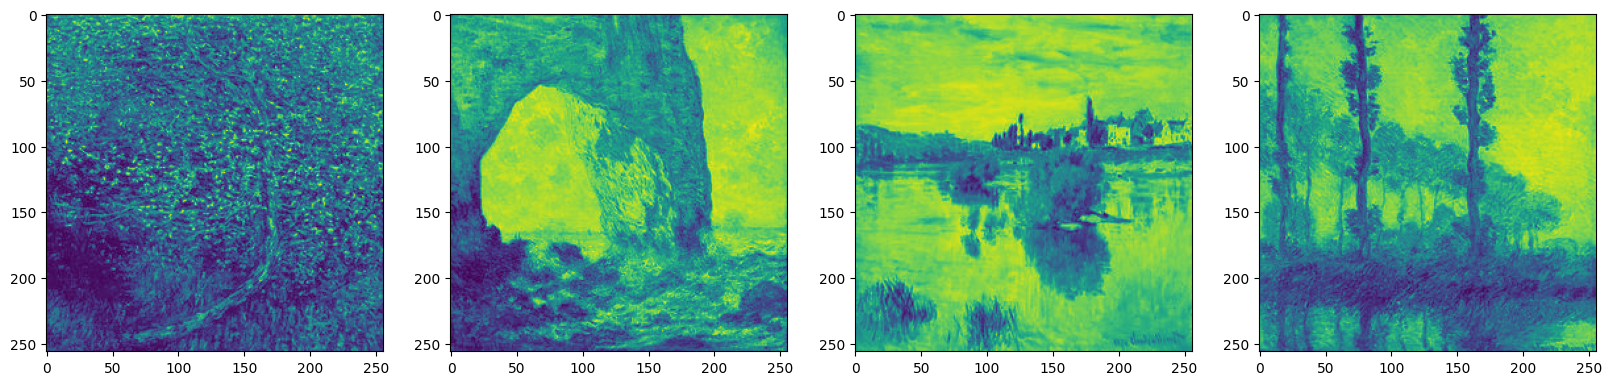

In [6]:
image_gen = dataset.batch(4).as_numpy_iterator()
plot_img = image_gen.next()
fig, ax = plt.subplots(ncols = 4, figsize = (20,20))

for idx,imag in enumerate(plot_img):
    ax[idx].imshow(np.squeeze(imag))
plt.show()

In [7]:
def scale_image(image):
 
    return image / 255

In [8]:
dataset = dataset.map(scale_image)
dataset = dataset.cache()
dataset = dataset.shuffle(301)
dataset = dataset.batch(16)
dataset = dataset.prefetch(64)


In [9]:
dataset.as_numpy_iterator().next().shape

(16, 256, 256, 1)

In [10]:
def build_gen():
    seq_model = Sequential()
    seq_model.add(Dense(16*16*128,input_dim = 16))
    seq_model.add(LeakyReLU(0.2))
    seq_model.add(Reshape((16,16,128)))
    
    
    seq_model.add(UpSampling2D())
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
    seq_model.add(UpSampling2D())
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
    seq_model.add(UpSampling2D())
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
    seq_model.add(UpSampling2D())
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
#     seq_model.add(UpSampling2D())
#     seq_model.add(Conv2D(150,4,padding="same"))
#     seq_model.add(LeakyReLU(0.2))
    
    seq_model.add(Conv2D(128,4,padding="same"))
    seq_model.add(LeakyReLU(0.2))
    
    
    seq_model.add(Conv2D(1,4,padding="same", activation="sigmoid"))
    return seq_model

In [11]:
model = build_gen()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32768)             557056    
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 32768)             0         
                                                                 
 reshape (Reshape)           (None, 16, 16, 128)       0         
                                                                 
 up_sampling2d (UpSampling2  (None, 32, 32, 128)       0         
 D)                                                              
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 128)       262272    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                        

In [12]:
image = model.predict(np.random.randn(2,16,1))
image

1/1 [==============================] - 1s 1s/step


array([[[[0.50078344],
         [0.50058657],
         [0.5006294 ],
         ...,
         [0.5000443 ],
         [0.4997376 ],
         [0.4996277 ]],

        [[0.50045675],
         [0.5000416 ],
         [0.50033194],
         ...,
         [0.4998795 ],
         [0.49968046],
         [0.49948546]],

        [[0.50075305],
         [0.500165  ],
         [0.5002702 ],
         ...,
         [0.49957737],
         [0.49960396],
         [0.49942175]],

        ...,

        [[0.5003354 ],
         [0.50027066],
         [0.5002089 ],
         ...,
         [0.50002307],
         [0.50002784],
         [0.49995938]],

        [[0.5002583 ],
         [0.5000829 ],
         [0.5001489 ],
         ...,
         [0.5001483 ],
         [0.50013256],
         [0.5000306 ]],

        [[0.5001558 ],
         [0.5001193 ],
         [0.5000888 ],
         ...,
         [0.50005454],
         [0.50004584],
         [0.50004584]]],


       [[[0.5007993 ],
         [0.5004666 ],
         [0.50

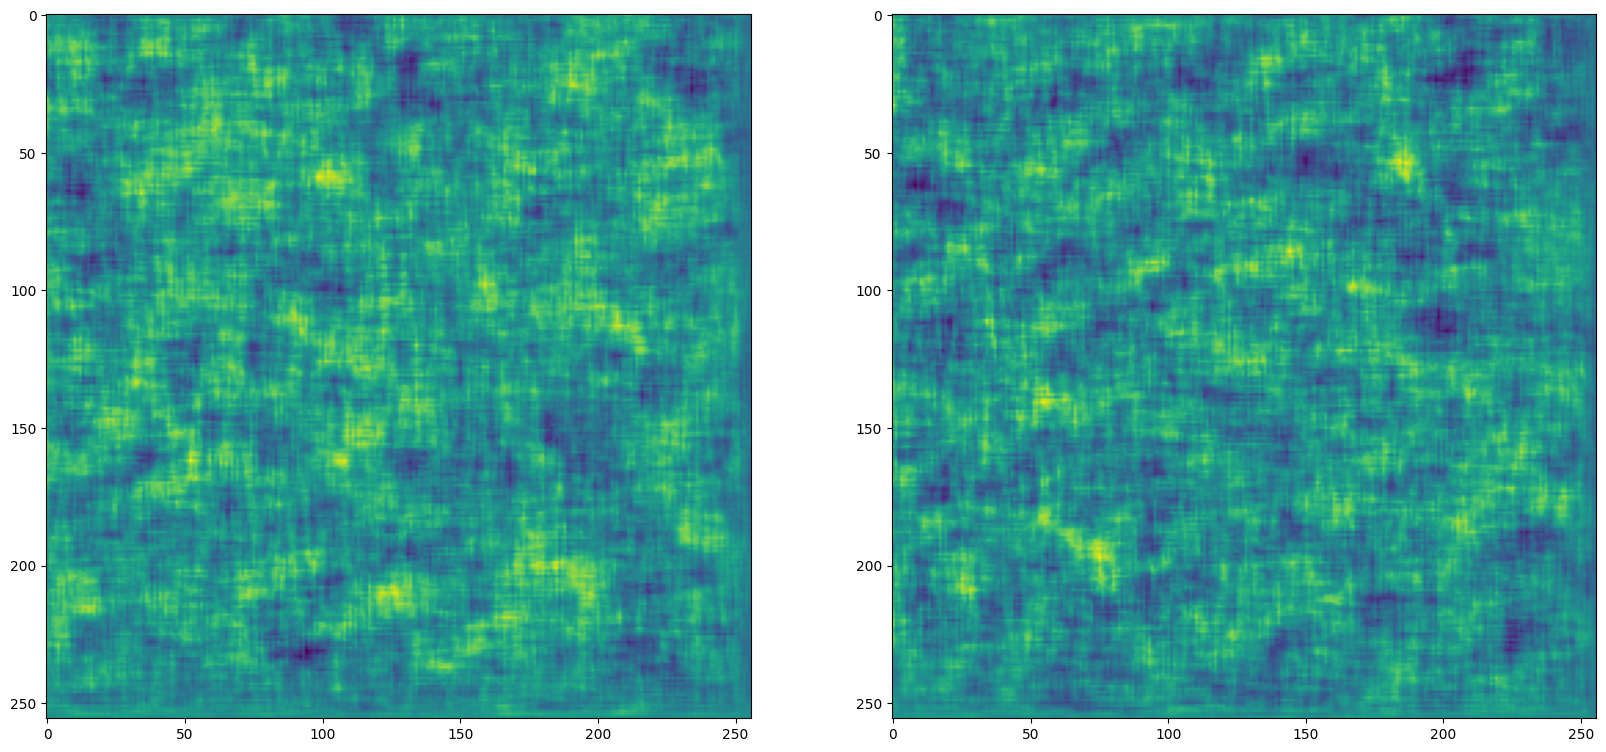

In [13]:
fig, ax = plt.subplots(ncols = 2, figsize = (20,20))

for idx,im in enumerate(image):
    ax[idx].imshow(np.squeeze(im))

    

In [14]:
def build_disc():
    model = Sequential()
    
    model.add(Conv2D(32, 5, input_shape = (256,256,1)))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(64, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(128, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))
    
    model.add(Conv2D(256, 5))
    model.add(LeakyReLU(0.2))
    model.add(Dropout(0.4))

    
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))
    return model

In [15]:
disc = build_disc()
disc.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 252, 252, 32)      832       
                                                                 
 leaky_re_lu_6 (LeakyReLU)   (None, 252, 252, 32)      0         
                                                                 
 dropout (Dropout)           (None, 252, 252, 32)      0         
                                                                 
 conv2d_7 (Conv2D)           (None, 248, 248, 64)      51264     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 248, 248, 64)      0         
                                                                 
 dropout_1 (Dropout)         (None, 248, 248, 64)      0         
                                                                 
 conv2d_8 (Conv2D)           (None, 244, 244, 128)    

In [16]:
plot_img.shape
image.shape

(2, 256, 256, 1)

In [17]:
## test the discriminator

disc.predict(image)

1/1 [==============================] - 2s 2s/step


array([[0.49253157],
       [0.4925212 ]], dtype=float32)

In [18]:
gen_opt = Adam(learning_rate=0.0001)
disc_opt = Adam(learning_rate=0.00001)
gen_loss = BinaryCrossentropy()
disc_loss = BinaryCrossentropy()

In [19]:
def train(real, gen_opt, disc_opt, gen_loss, disc_loss):
    gen = build_gen()
    disc = build_disc()
    
    
    for epoch in range(20):
        fake = gen(tf.random.normal((16, 16, 1)), training = False)
        image = real.as_numpy_iterator().next()
        with tf.GradientTape() as dtape:
            # Get the discriminator's predictions for real and fake images
            real_logits = disc(image, training = True)
            fake_logits = disc(fake, training = True)
            
            realfake_logits = tf.concat([real_logits, fake_logits], axis=0)
            
            # Create labels for real and fakes images
            logit_realfake = tf.concat([tf.zeros_like(real_logits), tf.ones_like(fake_logits)], axis=0)
            
            # Add some noise to the TRUE outputs
            noise_real = 0.15*tf.random.uniform(tf.shape(real_logits))
            noise_fake = -0.15*tf.random.uniform(tf.shape(fake_logits))
            logit_realfake += tf.concat([noise_real, noise_fake], axis=0)
            
            # Calculate loss - BINARYCROSS 
            total_d_loss = disc_loss(logit_realfake, realfake_logits)
            
        dgradients = dtape.gradient(total_d_loss, disc.trainable_variables)
        disc_opt.apply_gradients(zip(dgradients, disc.trainable_variables))
            
        with tf.GradientTape() as gtape:

            fake = gen(tf.random.normal((16, 16, 1)), training = True)
            # Get the discriminator's predictions for fake images
            fake_logits = disc(fake, training = False)

            # Calculate the generator's loss
            g_loss = gen_loss(tf.zeros_like(fake_logits), fake_logits)

        # Update the generator's weights
        gen_gradients = gtape.gradient(g_loss, gen.trainable_variables)
        gen_opt.apply_gradients(zip(gen_gradients, gen.trainable_variables))

In [20]:
train(dataset,gen_opt, disc_opt, gen_loss, disc_loss)

1/1 [==============================] - 8s 8s/step


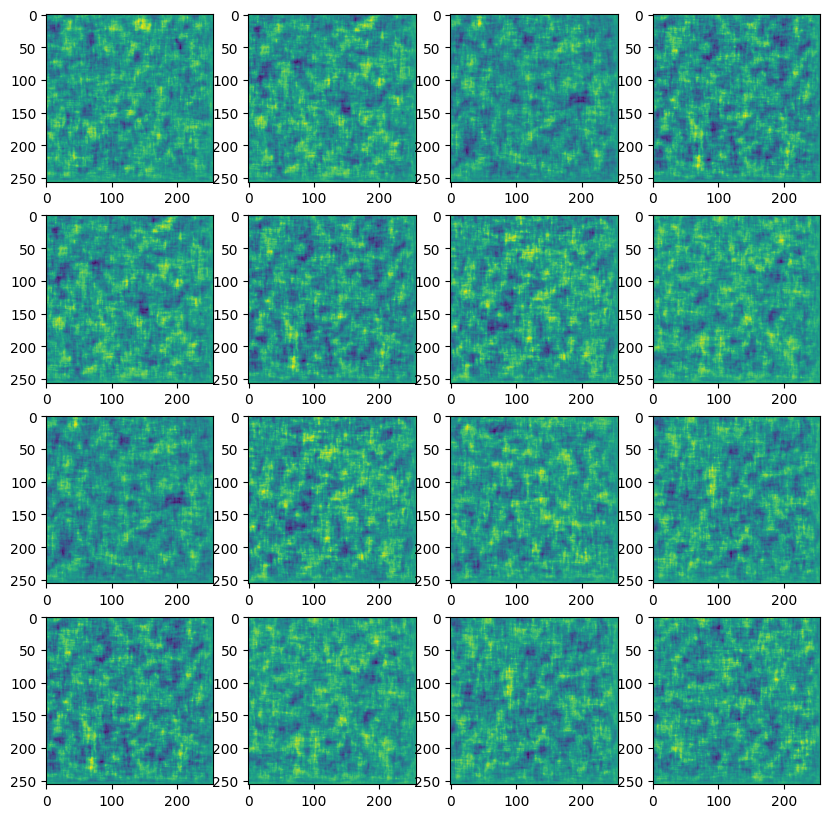

In [21]:
generator = build_gen()
imgs = generator.predict(tf.random.normal((16, 16, 1)))
fig, ax = plt.subplots(ncols=4, nrows=4, figsize=(10,10))
for r in range(4): 
    for c in range(4): 
        ax[r][c].imshow(imgs[(r+1)*(c+1)-1])